#### Import necessary libraries

In [81]:
import torch
from torch import nn
from torch import optim
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

#### Prepare Data for Training

In [35]:
data = fetch_california_housing()
print(f'Feature names: {data.feature_names}')
X, y = data.data, data.target
print(f'Features shape: {X.shape}\nLabel shape: {y.shape}')
print(f'Single data point features: {X[0]}')
print(f'Single data point label: {y[0]}')

Feature names: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Features shape: (20640, 8)
Label shape: (20640,)
Single data point features: [   8.3252       41.            6.98412698    1.02380952  322.
    2.55555556   37.88       -122.23      ]
Single data point label: 4.526


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
standard_scaler = StandardScaler().fit(X_train)
X_train = standard_scaler.transform(X_train)
X_test = standard_scaler.transform(X_test)
print(f'Single data point features: {X_train[0]}')

Single data point features: [-0.66799975  0.66905917 -0.65979216  0.01685023  0.37795143 -0.23580601
  1.0184647  -1.34097203]


In [38]:
class HousingData(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        return self.features[index], self.labels[index]

X_train = torch.from_numpy(X_train).type(torch.float32)
X_test = torch.from_numpy(X_test).type(torch.float32)
y_train = torch.from_numpy(y_train).type(torch.float32)
y_test = torch.from_numpy(y_test).type(torch.float32)
train_data = HousingData(features=X_train, labels=y_train)
test_data = HousingData(features=X_test, labels=y_test)

In [39]:
train_loader = DataLoader(
    dataset=train_data,
    batch_size=64,
    shuffle=True
)

test_loader = DataLoader(
    dataset = test_data,
    batch_size=64,
    shuffle=False
)

#### Define Model and Hyperparameters

In [76]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Linear(8, 24),
            nn.ReLU(),
            nn.Linear(24, 12),
            nn.ReLU(),
            nn.Linear(12, 6),
            nn.ReLU(),
            nn.Linear(6, 1)
        )
    
    def forward(self, x):
        return self.sequential(x)

In [77]:
model = Model()
model

Model(
  (sequential): Sequential(
    (0): Linear(in_features=8, out_features=24, bias=True)
    (1): ReLU()
    (2): Linear(in_features=24, out_features=12, bias=True)
    (3): ReLU()
    (4): Linear(in_features=12, out_features=6, bias=True)
    (5): ReLU()
    (6): Linear(in_features=6, out_features=1, bias=True)
  )
)

In [78]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(params=model.parameters(), lr=0.001)
epochs = 50

#### Define Training, Testing and Eval Functions

In [79]:
def train_step(model, data_loader, loss_fn, optimizer):
    train_loss = 0
    model.train()
    for batch_idx, (X, y) in enumerate(data_loader):
        y_pred = model(X)
        loss = loss_fn(y_pred.squeeze(), y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(data_loader)
    print(f'Train loss: {train_loss:.5f}')
    return train_loss

def test_step(model, data_loader, loss_fn):
    test_loss = 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            y_pred = model(X)
            loss = loss_fn(y_pred.squeeze(), y)
            test_loss += loss.item()
    test_loss /= len(data_loader)
    print(f'Test loss: {test_loss:.5f}')
    return test_loss

def eval_mode(model, data_loader, loss_fn):
    loss = 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            y_pred = model(X)
            loss += loss_fn(y_pred.squeeze(), y).item()
    loss /= len(data_loader)
    print(f'Final loss: {loss:.5f}')

In [80]:
train_losses, test_losses, epoch_count = [], [], []
for epoch in range(epochs):
    print(f'Epoch: {epoch}\n-------------')
    train_loss = train_step(model, train_loader, loss_fn, optimizer)
    test_loss = test_step(model, test_loader, loss_fn)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    epoch_count.append(epoch)

print(f'Evaluating model:\n')
eval_mode(model, test_loader, loss_fn)

Epoch: 0
-------------
Train loss: 1.73668
Test loss: 0.97755
Epoch: 1
-------------
Train loss: 0.50603
Test loss: 0.46431
Epoch: 2
-------------
Train loss: 0.42117
Test loss: 0.40637
Epoch: 3
-------------
Train loss: 0.39214
Test loss: 0.39388
Epoch: 4
-------------
Train loss: 0.37681
Test loss: 0.38053
Epoch: 5
-------------
Train loss: 0.36673
Test loss: 0.37743
Epoch: 6
-------------
Train loss: 0.36074
Test loss: 0.36652
Epoch: 7
-------------
Train loss: 0.35511
Test loss: 0.36521
Epoch: 8
-------------
Train loss: 0.34989
Test loss: 0.35520
Epoch: 9
-------------
Train loss: 0.34551
Test loss: 0.38308
Epoch: 10
-------------
Train loss: 0.34130
Test loss: 0.34966
Epoch: 11
-------------
Train loss: 0.33668
Test loss: 0.33897
Epoch: 12
-------------
Train loss: 0.33150
Test loss: 0.36208
Epoch: 13
-------------
Train loss: 0.32793
Test loss: 0.32877
Epoch: 14
-------------
Train loss: 0.32241
Test loss: 0.33106
Epoch: 15
-------------
Train loss: 0.31968
Test loss: 0.32062
Ep

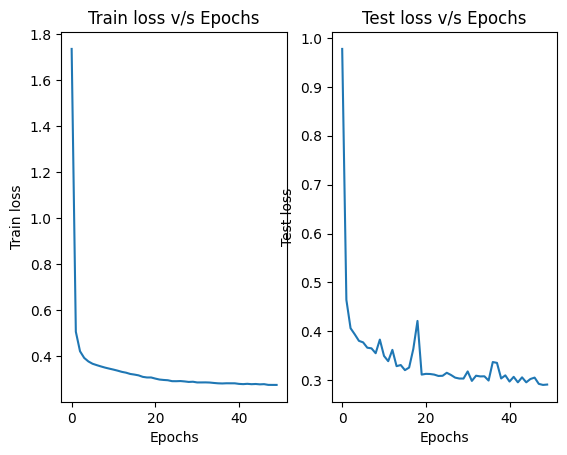

In [84]:
plt.subplot(1, 2, 1)
plt.plot(epoch_count, train_losses)
plt.ylabel('Train loss')
plt.xlabel('Epochs')
plt.title('Train loss v/s Epochs')
plt.subplot(1, 2, 2)
plt.plot(epoch_count, test_losses)
plt.ylabel('Test loss')
plt.xlabel('Epochs')
plt.title('Test loss v/s Epochs')
plt.show()